# Example 9: Cell Viability Measurement

In this notebook we normalize different fluorescent intensity signs to provide normalized cell viability measurement. For beginning let's start with two channels cases, that $I_1$ is high indicating low viability (negative/death signals), and $I_2$ is high for high viability (positive/live signals):

$$\text{Viability}(I_1,I_2) = \frac{1}{1+0.5(e^{-10\cdot(0.5-I_1)}+e^{-10\cdot(I_2-0.5)})}$$

We may generalize it to the formulation:
- ${I_1,I_2,...I_N}$ is the set of intensities of measurement channels.
- Positive signal indexed by the set $P$.
- Negative signal index by the set $N$.
- With pre-normalized channel range to $[0,1]$
Assume a similar exponential sensitivity for each channel, with a shift of 0.5 as the neutral value. Then the generalized viability function for any number of channels becomes:

$$\text{Viability}(I_1,I_2,...,I_N) = \frac{1}{1+\frac{1}{|P|+|N|}(\sum_{i\in P}e^{-10\cdot(I_i-0.5)}+\sum_{j\in N}e^{-10\cdot(0.5-I_j)})}$$
​
Where:

- $\sum_{i\in P}e^{-10\cdot(I_i-0.5)}$ sums the contributions of all positive channels (where higher intensity indicates greater viability).
- $\sum_{j\in N}e^{-10\cdot(0.5-I_j)}$ sums the contributions of all negative channels (where higher intensity indicates lower viability).
- $|P|$ and $|N|$ are the number of positive and negative channels, respectively.
- The scaling factor $\frac{1}{|P|+|N|}$ ensures that the viability function remains properly normalized across any number of channels.

This generalization ensures that signals from any number of channels, both positive and negative, are combined to produce a viability score between 0 and 1.

## Headers

In [1]:
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
import numpy as np
from cyto.postprocessing.sparse_to_sparse import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
client = Client()
client

/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38259 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:45625' processes=8 threads=32, memory=251.55 GiB>

## Data Loading

In [3]:
tracks_gfp_df = dd.read_csv("/mnt/Data/UTSE/2023_10_03_Nyeso1_HCT116_framerate_10sec_flowrate_0p15mlperh_analysis/tracks/20231003_roi-5_0-2899_binT-1_cancer/tracks_remapped.csv")
tracks_gfp_df

Dask DataFrame Structure:
               Unnamed: 0  label        y        x bbox_xstart bbox_ystart bbox_xsize bbox_ysize        i        j bbox_istart bbox_jstart bbox_isize bbox_jsize     size elongation flatness roundness feret_diameter feret_radius perimeter     mass     mean   median       sd  frame channel    alive track_id     id dist_from_ultrack tracked frames tracked length mean tracked cell size
npartitions=35                                                                                                                                                                                                                                                                                                                                                                                  
                    int64  int64  float64  float64       int64       int64      int64      int64  float64  float64     float64     float64    float64    float64  float64    float64  float64   float64        float64      float64   float64  float64  float64  float64  float64  int64  object  float64    int64  int64           float64          int64          int64                float64
                      ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...
...                   ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...
                      ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...
                      ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...
Dask Name: read-csv, 1 graph layer

In [4]:
tracks_pi_df = dd.read_csv("/mnt/Data/UTSE/2023_10_03_Nyeso1_HCT116_framerate_10sec_flowrate_0p15mlperh_analysis/tracks/20231003_roi-5_0-2899_binT-1_cancer/tracks_pi_remapped.csv")
tracks_pi_df

Dask DataFrame Structure:
               Unnamed: 0  label        y        x bbox_xstart bbox_ystart bbox_xsize bbox_ysize        i        j bbox_istart bbox_jstart bbox_isize bbox_jsize     size elongation flatness roundness feret_diameter feret_radius perimeter     mass     mean   median       sd  frame channel    alive track_id     id dist_from_ultrack tracked frames tracked length mean tracked cell size
npartitions=35                                                                                                                                                                                                                                                                                                                                                                                  
                    int64  int64  float64  float64       int64       int64      int64      int64  float64  float64     float64     float64    float64    float64  float64    float64  float64   float64        float64      float64   float64  float64  float64  float64  float64  int64  object  float64    int64  int64           float64          int64          int64                float64
                      ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...
...                   ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...
                      ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...
                      ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...
Dask Name: read-csv, 1 graph layer

In [5]:
tracks_gfp_df_norm = intensity_norm(tracks_gfp_df,channel="mean", percentile=1)
tracks_gfp_df_norm

Dask DataFrame Structure:
               Unnamed: 0  label        y        x bbox_xstart bbox_ystart bbox_xsize bbox_ysize        i        j bbox_istart bbox_jstart bbox_isize bbox_jsize     size elongation flatness roundness feret_diameter feret_radius perimeter     mass     mean   median       sd  frame channel    alive track_id     id dist_from_ultrack tracked frames tracked length mean tracked cell size mean_norm
npartitions=35                                                                                                                                                                                                                                                                                                                                                                                            
                    int64  int64  float64  float64       int64       int64      int64      int64  float64  float64     float64     float64    float64    float64  float64    float64  float64   float64        float64      float64   float64  float64  float64  float64  float64  int64  object  float64    int64  int64           float64          int64          int64                float64   float64
                      ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...       ...
...                   ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...       ...
                      ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...       ...
                      ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...       ...
Dask Name: assign, 18 graph layers

In [6]:
tracks_pi_df_norm = intensity_norm(tracks_pi_df,channel="mean", percentile=1)
tracks_pi_df_norm

Dask DataFrame Structure:
               Unnamed: 0  label        y        x bbox_xstart bbox_ystart bbox_xsize bbox_ysize        i        j bbox_istart bbox_jstart bbox_isize bbox_jsize     size elongation flatness roundness feret_diameter feret_radius perimeter     mass     mean   median       sd  frame channel    alive track_id     id dist_from_ultrack tracked frames tracked length mean tracked cell size mean_norm
npartitions=35                                                                                                                                                                                                                                                                                                                                                                                            
                    int64  int64  float64  float64       int64       int64      int64      int64  float64  float64     float64     float64    float64    float64  float64    float64  float64   float64        float64      float64   float64  float64  float64  float64  float64  int64  object  float64    int64  int64           float64          int64          int64                float64   float64
                      ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...       ...
...                   ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...       ...
                      ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...       ...
                      ...    ...      ...      ...         ...         ...        ...        ...      ...      ...         ...         ...        ...        ...      ...        ...      ...       ...            ...          ...       ...      ...      ...      ...      ...    ...     ...      ...      ...    ...               ...            ...            ...                    ...       ...
Dask Name: assign, 18 graph layers

In [7]:
track_gfp_df_norm = tracks_gfp_df_norm.rename(
    columns={
        "mean": "GFP mean",
        "median": "GFP median",
        "sd": "GFP sd",
        "mean_norm": "GFP mean norm"
    }
)

track_pi_df_norm = tracks_pi_df_norm.rename(
    columns={
        "mean": "PI mean",
        "median": "PI median",
        "sd": "PI sd",
        "mean_norm": "PI mean norm"
    }
)

In [8]:
# compute the ddf to df
track_gfp_df_norm = track_gfp_df_norm.compute()
track_pi_df_norm = track_pi_df_norm.compute()

In [9]:
track = left_table_merge(track_gfp_df_norm, track_pi_df_norm, on='label')
track

Unnamed: 0    label           y           x  bbox_xstart  \
0               425      426   24.235772    5.800813            0   
1               240      241    9.649180   22.498361           11   
2               384      385    9.101562    8.312500            0   
3              1013     1014  135.993631    8.592357            2   
4              1241     1242  124.785185    3.059259            0   
...             ...      ...         ...         ...          ...   
6166317         610  6773032  712.942308  455.788462          447   
6166318        2158  6774580   40.339623  734.292453          729   
6166319        2590  6775012   31.705882  743.911765          742   
6166320        1262  6773684  444.841808  970.751412          965   
6166321        1302  6773724  451.908046  987.908046          980   

         bbox_ystart  bbox_xsize  bbox_ysize           i           j  ...  \
0                  8          15          27    5.800813   24.235772  ...   
1                  0          21          22   22.498361    9.649180  ...   
2                  0          17          21    8.312500    9.101562  ...   
3                128          14          16    8.592357  135.993631  ...   
4                115          10          23    3.059259  124.785185  ...   
...              ...         ...         ...         ...         ...  ...   
6166317          703          21          26  455.788462  712.942308  ...   
6166318           35          13          12  734.292453   40.339623  ...   
6166319           28           5           8  743.911765   31.705882  ...   
6166320          435          13          23  970.751412  444.841808  ...   
6166321          445          17          15  987.908046  451.908046  ...   

                 id  dist_from_ultrack  tracked frames  tracked length  \
0           1000025           0.308649             910             919   
1           1000028           0.609457             156             159   
2           1000029           0.328590              50              51   
3           1000039           0.407693             291             291   
4           1000040           0.222839             331             331   
...             ...                ...             ...             ...   
6166317  2900011772           2.789058              66              81   
6166318  2900014130           0.448188              63              81   
6166319  2900014124          11.110681              20              80   
6166320  2900016071           0.294653              63              64   
6166321  2900016607           0.130043              80              80   

         mean tracked cell size  GFP mean norm     PI mean   PI median  \
0                    219.029670       0.304966  110.882114  113.144531   
1                    302.897436       0.444950  119.688525  113.144531   
2                    181.500000       0.449540  111.070312  113.144531   
3                    153.859107       0.078745  110.484076  113.144531   
4                     99.465257       0.317351  111.600000  113.144531   
...                         ...            ...         ...         ...   
6166317              265.257576       0.357829  112.869231  133.328125   
6166318              113.333333       0.014074  112.547170  133.328125   
6166319              197.150000       0.009580  111.882353  133.328125   
6166320              115.365079       0.401688  120.943503  133.328125   
6166321              256.125000       0.277461  115.183908  133.328125   

             PI sd  PI mean norm  
0         2.638476      0.000563  
1        13.639799      0.018317  
2         2.964320      0.000943  
3         2.680904      0.000000  
4         3.453746      0.002010  
...            ...           ...  
6166317   2.920804      0.004569  
6166318   2.704959      0.003920  
6166319   2.070935      0.002580  
6166320   6.469963      0.020847  
6166321   3.460859      0.009235  

[6166322 rows x 39 columns]

## Viability Calculation

In [10]:
track_via = cal_viability(track,pos_cols=["GFP mean norm"], neg_cols=["PI mean norm"])
track

Unnamed: 0    label           y           x  bbox_xstart  \
0               425      426   24.235772    5.800813            0   
1               240      241    9.649180   22.498361           11   
2               384      385    9.101562    8.312500            0   
3              1013     1014  135.993631    8.592357            2   
4              1241     1242  124.785185    3.059259            0   
...             ...      ...         ...         ...          ...   
6166317         610  6773032  712.942308  455.788462          447   
6166318        2158  6774580   40.339623  734.292453          729   
6166319        2590  6775012   31.705882  743.911765          742   
6166320        1262  6773684  444.841808  970.751412          965   
6166321        1302  6773724  451.908046  987.908046          980   

         bbox_ystart  bbox_xsize  bbox_ysize           i           j  ...  \
0                  8          15          27    5.800813   24.235772  ...   
1                  0          21          22   22.498361    9.649180  ...   
2                  0          17          21    8.312500    9.101562  ...   
3                128          14          16    8.592357  135.993631  ...   
4                115          10          23    3.059259  124.785185  ...   
...              ...         ...         ...         ...         ...  ...   
6166317          703          21          26  455.788462  712.942308  ...   
6166318           35          13          12  734.292453   40.339623  ...   
6166319           28           5           8  743.911765   31.705882  ...   
6166320          435          13          23  970.751412  444.841808  ...   
6166321          445          17          15  987.908046  451.908046  ...   

         dist_from_ultrack  tracked frames  tracked length  \
0                 0.308649             910             919   
1                 0.609457             156             159   
2                 0.328590              50              51   
3                 0.407693             291             291   
4                 0.222839             331             331   
...                    ...             ...             ...   
6166317           2.789058              66              81   
6166318           0.448188              63              81   
6166319          11.110681              20              80   
6166320           0.294653              63              64   
6166321           0.130043              80              80   

         mean tracked cell size  GFP mean norm     PI mean   PI median  \
0                    219.029670       0.304966  110.882114  113.144531   
1                    302.897436       0.444950  119.688525  113.144531   
2                    181.500000       0.449540  111.070312  113.144531   
3                    153.859107       0.078745  110.484076  113.144531   
4                     99.465257       0.317351  111.600000  113.144531   
...                         ...            ...         ...         ...   
6166317              265.257576       0.357829  112.869231  133.328125   
6166318              113.333333       0.014074  112.547170  133.328125   
6166319              197.150000       0.009580  111.882353  133.328125   
6166320              115.365079       0.401688  120.943503  133.328125   
6166321              256.125000       0.277461  115.183908  133.328125   

             PI sd  PI mean norm  viability  
0         2.638476      0.000563   0.221291  
1        13.639799      0.018317   0.534443  
2         2.964320      0.000943   0.545981  
3         2.680904      0.000000   0.028762  
4         3.453746      0.002010   0.243341  
...            ...           ...        ...  
6166317   2.920804      0.004569   0.325138  
6166318   2.704959      0.003920   0.015275  
6166319   2.070935      0.002580   0.014613  
6166320   6.469963      0.020847   0.427251  
6166321   3.460859      0.009235   0.177549  

[6166322 rows x 40 columns]

### Viability Gradient

In [11]:
track_via_grad = compute_smoothed_gradient(track_via, track_id_col='track_id', frame_col='frame', value_col='viability', sigma=2, ma_window=20, smooth_method="ma",grad_method="forward")
track_via_grad

/home/jackyko/Projects/Cytotoxicity-Pipeline/cyto/postprocessing/sparse_to_sparse.py:188: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ).interpolate().reset_index()
/home/jackyko/Projects/Cytotoxicity-Pipeline/cyto/postprocessing/sparse_to_sparse.py:188: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ).interpolate().reset_index()
/home/jackyko/Projects/Cytotoxicity-Pipeline/cyto/postprocessing/sparse_to_sparse.py:188: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ).interpolate().reset_index()
/home/jackyko/Projects/Cytotoxicity-Pipeline/cyto/postprocessing/sparse_to_sparse.py:188: FutureWarning: DataFrame.interpola

Unnamed: 0    label           y           x  bbox_xstart  \
0               425      426   24.235772    5.800813            0   
1               240      241    9.649180   22.498361           11   
2               384      385    9.101562    8.312500            0   
3              1013     1014  135.993631    8.592357            2   
4              1241     1242  124.785185    3.059259            0   
...             ...      ...         ...         ...          ...   
6166317         610  6773032  712.942308  455.788462          447   
6166318        2158  6774580   40.339623  734.292453          729   
6166319        2590  6775012   31.705882  743.911765          742   
6166320        1262  6773684  444.841808  970.751412          965   
6166321        1302  6773724  451.908046  987.908046          980   

         bbox_ystart  bbox_xsize  bbox_ysize           i           j  ...  \
0                  8          15          27    5.800813   24.235772  ...   
1                  0          21          22   22.498361    9.649180  ...   
2                  0          17          21    8.312500    9.101562  ...   
3                128          14          16    8.592357  135.993631  ...   
4                115          10          23    3.059259  124.785185  ...   
...              ...         ...         ...         ...         ...  ...   
6166317          703          21          26  455.788462  712.942308  ...   
6166318           35          13          12  734.292453   40.339623  ...   
6166319           28           5           8  743.911765   31.705882  ...   
6166320          435          13          23  970.751412  444.841808  ...   
6166321          445          17          15  987.908046  451.908046  ...   

         tracked length  mean tracked cell size  GFP mean norm     PI mean  \
0                   919              219.029670       0.304966  110.882114   
1                   159              302.897436       0.444950  119.688525   
2                    51              181.500000       0.449540  111.070312   
3                   291              153.859107       0.078745  110.484076   
4                   331               99.465257       0.317351  111.600000   
...                 ...                     ...            ...         ...   
6166317              81              265.257576       0.357829  112.869231   
6166318              81              113.333333       0.014074  112.547170   
6166319              80              197.150000       0.009580  111.882353   
6166320              64              115.365079       0.401688  120.943503   
6166321              80              256.125000       0.277461  115.183908   

          PI median      PI sd  PI mean norm  viability  viability_smoothed  \
0        113.144531   2.638476      0.000563   0.221291            0.116423   
1        113.144531  13.639799      0.018317   0.534443            0.245910   
2        113.144531   2.964320      0.000943   0.545981            0.289771   
3        113.144531   2.680904      0.000000   0.028762            0.014547   
4        113.144531   3.453746      0.002010   0.243341            0.116534   
...             ...        ...           ...        ...                 ...   
6166317  133.328125   2.920804      0.004569   0.325138            0.164768   
6166318  133.328125   2.704959      0.003920   0.015275            0.008498   
6166319  133.328125   2.070935      0.002580   0.014613            0.026598   
6166320  133.328125   6.469963      0.020847   0.427251            0.267341   
6166321  133.328125   3.460859      0.009235   0.177549            0.098130   

         viability_grad  
0              0.011889  
1              0.021439  
2              0.029739  
3              0.001473  
4              0.009948  
...                 ...  
6166317       -0.013951  
6166318       -0.000785  
6166319       -0.002342  
6166320       -0.026243  
6166321       -0.008678  

[6166322 rows x 42 columns]

## Plot Viability as Function of Time

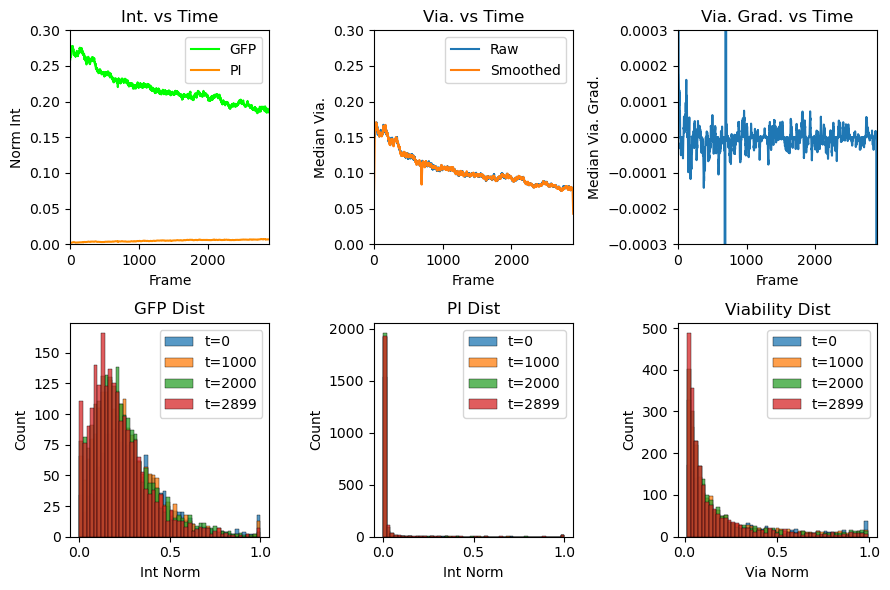

In [12]:
fig, axs = plt.subplots(2,3,figsize=(9,6))

axs[0,0].plot(track_via_grad.groupby('frame')['GFP mean norm'].median(), label="GFP", c="lime")
axs[0,0].plot(track_via_grad.groupby('frame')['PI mean norm'].median(), label="PI", c="darkorange")
axs[0,0].set_xlim(0,track_via["frame"].max() )
axs[0,0].set_ylim(0,0.3)
axs[0,0].set_ylabel("Norm Int")
axs[0,0].set_xlabel("Frame")
axs[0,0].set_title("Int. vs Time")
axs[0,0].legend()

axs[0,1].plot(track_via_grad.groupby('frame')['viability'].median(),label="Raw")
axs[0,1].plot(track_via_grad.groupby('frame')['viability_smoothed'].median(),label="Smoothed")
axs[0,1].set_ylabel("Median Via.")
axs[0,1].set_xlabel("Frame")
axs[0,1].set_title("Via. vs Time")
axs[0,1].set_xlim(0,track_via["frame"].max() )
axs[0,1].set_ylim(0,0.3)
axs[0,1].legend()

axs[0,2].plot(track_via_grad.groupby('frame')['viability_grad'].median())
axs[0,2].set_ylabel("Median Via. Grad.")
axs[0,2].set_xlabel("Frame")
axs[0,2].set_title("Via. Grad. vs Time")
axs[0,2].set_xlim(0,track_via["frame"].max() )
axs[0,2].set_ylim(-3e-4,3e-4)

axs[1,0].set_title("GFP Dist")
sns.histplot(track_via_grad[track_via_grad["frame"]==0]['GFP mean norm'], binwidth=0.02, label="t=0", ax=axs[1,0])
sns.histplot(track_via_grad[track_via_grad["frame"]==1000]['GFP mean norm'], binwidth=0.02, label="t=1000", ax=axs[1,0])
sns.histplot(track_via_grad[track_via_grad["frame"]==2000]['GFP mean norm'], binwidth=0.02, label="t=2000", ax=axs[1,0])
sns.histplot(track_via_grad[track_via_grad["frame"]==2899]['GFP mean norm'], binwidth=0.02, label="t=2899", ax=axs[1,0])
axs[1,0].legend()
axs[1,0].set_xlabel("Int Norm")

axs[1,1].set_title("PI Dist")
sns.histplot(track_via_grad[track_via_grad["frame"]==0]['PI mean norm'], binwidth=0.02, label="t=0", ax=axs[1,1])
sns.histplot(track_via_grad[track_via_grad["frame"]==1000]['PI mean norm'], binwidth=0.02, label="t=1000", ax=axs[1,1])
sns.histplot(track_via_grad[track_via_grad["frame"]==2000]['PI mean norm'], binwidth=0.02, label="t=2000", ax=axs[1,1])
sns.histplot(track_via_grad[track_via_grad["frame"]==2899]['PI mean norm'], binwidth=0.02, label="t=2899", ax=axs[1,1])
axs[1,1].legend()
axs[1,1].set_xlabel("Int Norm")

axs[1,2].set_title("Viability Dist")
sns.histplot(track_via_grad[track_via_grad["frame"]==0]['viability'], binwidth=0.02, label="t=0", ax=axs[1,2])
sns.histplot(track_via_grad[track_via_grad["frame"]==1000]['viability'], binwidth=0.02, label="t=1000", ax=axs[1,2])
sns.histplot(track_via_grad[track_via_grad["frame"]==2000]['viability'], binwidth=0.02, label="t=2000", ax=axs[1,2])
sns.histplot(track_via_grad[track_via_grad["frame"]==2899]['viability'], binwidth=0.02, label="t=2899", ax=axs[1,2])
axs[1,2].legend()
axs[1,2].set_xlabel("Via Norm")

plt.tight_layout()